# Importing Libraries

In [25]:
import math
import numpy as np

In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

# To run on hardware, selectthe backedn with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
# backend.name

In [27]:
from qiskit.quantum_info import Statevector, Operator
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_distribution
import qiskit.circuit.library as qulib
from qiskit_aer import AerSimulator
from qiskit.result import marginal_distribution
from qiskit import transpile

In [51]:
def TridiagonalBlockEncoding(m,arr):
    # Sparse Block encoding according to paper van Daan Camps 2023 Explicit block encoding of sparse matrices
    n = 2 # Number of Ancilla Qubits
    # s = 2 ** m sparsity
    # n - number of qubits
    Tridiagblckencd = QuantumCircuit(n+m+1,name="Tridiagblckencd")
    # print("Size of the Matrix: ",m)
    # print("Number of Ancilla qubits: ",n+1)

    # Diffusion Operator
    Diffusion = QuantumCircuit(n,name="Diffusion")
    Diffusion.h(range(n))
    Tridiagblckencd.append(Diffusion, list(range(1,n+1)))

    #OA circuit
    OA = QuantumCircuit(n+m+1,name="OA")
    theta0=2*np.arccos(arr[1]-1)
    theta1=2*np.arccos(arr[2])
    theta2=2*np.arccos(arr[0])
    
    # print(theta2)
    # print(theta0)
    # print(theta1)
    
    OA.append(qulib.RYGate(theta0).control(2,ctrl_state="00"),[2,1,0])
    OA.append(qulib.RYGate(theta1).control(2,ctrl_state="01"),[2,1,0])
    OA.append(qulib.RYGate(theta2).control(2,ctrl_state="10"),[2,1,0])
    str="01"+"1"*m
    OA.append(qulib.RYGate(np.pi - theta1).control(n+m,ctrl_state=str),list(range(n+m,-1,-1)))
    str="10"+"0"*m
    OA.append(qulib.RYGate(np.pi - theta2).control(n+m,ctrl_state=str),list(range(n+m,-1,-1)))

    Tridiagblckencd.append(OA, list(range(0,n+m+1)))
    
    #Oc Circuit
    Oc = QuantumCircuit(n+m,name="Oc")
    #Lshift Operator
    Lshift = QuantumCircuit(m,name="Lshift")
    for i in range(m-1):
        Lshift.append(qulib.XGate().control(m-i-1),list(range(m-1,i-1,-1)))
    Lshift.x(m-1)
    Oc.append(qulib.UnitaryGate(Operator(Lshift),label="Lshift").control(1),[1]+list(range(n,n+m)))
    
    #RShift Operator
    Rshift = QuantumCircuit(m,name="Rshift")
    for i in range(m-1):
        str='0'*(m-i-1)
        Rshift.append(qulib.XGate().control(m-i-1,ctrl_state=str),list(range(m-1,i-1,-1)))
    Rshift.x(m-1)
    Oc.append(qulib.UnitaryGate(Operator(Rshift),label="Rshift").control(1),[0]+list(range(n,n+m)))
   
    Tridiagblckencd.append(Oc, list(range(1,n+m+1)))

    # Diffusion Operator
    Tridiagblckencd.append(Diffusion, list(range(1,n+1)))
    
    return Tridiagblckencd
    

## Parameters

In [29]:
# Required conditions
m = 5 # n=5 number of qubits chosen to implement the matrix, N=2**n
delta = 1.6 # divide by this parameter to make the matrix spectral norm less than 1
M = 2**m # Dimension of the matrix
s = 3 # Sparsity
r = int(np.ceil(np.log2(s)))

# Matrix Parameters
Vx = -0.5 # Vx chosen
alpha = 1 + Vx # Diagonal entry
beta = -0.5 # sub-diagonal entry
gamma= -0.5 # Super-diagonal entry

print("Dimension of Matrix: ",M)
print("Sparsity: ",s)
print("Number of Ancilla qubits: ", r+1)
print("Total Number of Qubits: ", m+r+1)

Dimension of Matrix:  32
Sparsity:  3
Number of Ancilla qubits:  3
Total Number of Qubits:  8


Note that both the constraints for block encoding of general s-sparse matrix which are $\|A\|_{max} = \max_{ij} |A_{ij}| \leq 1$ and $\|A\|_2 \leq 1$ are followed. 

In [30]:
super_diag = np.ones(M-1) * gamma
main_diag = np.ones(M) * alpha
sub_diag = np.ones(M-1) * beta

tridiag_A = np.diag(main_diag) + np.diag(sub_diag, k=-1) + np.diag(super_diag, k=1)
tridiag_A = tridiag_A/delta
print("The matrix is:\n", tridiag_A)
print("The matrix spectral Norm is: ",np.linalg.norm(tridiag_A,ord=2))
print(" The maximum value in the matrix is: ", )

The matrix is:
 [[ 0.3125 -0.3125  0.     ...  0.      0.      0.    ]
 [-0.3125  0.3125 -0.3125 ...  0.      0.      0.    ]
 [ 0.     -0.3125  0.3125 ...  0.      0.      0.    ]
 ...
 [ 0.      0.      0.     ...  0.3125 -0.3125  0.    ]
 [ 0.      0.      0.     ... -0.3125  0.3125 -0.3125]
 [ 0.      0.      0.     ...  0.     -0.3125  0.3125]]
The matrix spectral Norm is:  0.934669951608178
 The maximum value in the matrix is: 


#### Solving Eigenvalue problem classically, 
we have to diagonalize the matrix of size $2^N \times 2^N$ where $N$ is the number of qubits. This is computationally expensive and not feasible for large $N$.

In [31]:
#Eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(tridiag_A)
print("Eigenvalues of A:")
print(eigenvalues)
print("Eigenvectors of A:")
print(eigenvectors)

Eigenvalues of A:
[-3.09669952e-01 -3.01205436e-01 -2.87183109e-01 -2.67729958e-01
 -2.43022155e-01 -2.13283458e-01 -1.78783184e-01 -1.39833774e-01
 -9.67879587e-02 -5.00355685e-02 -3.51159794e-17  5.28656169e-02
  1.08082523e-01  1.65150665e-01  2.23553226e-01  2.82761303e-01
  3.42238697e-01  4.01446774e-01  4.59849335e-01  5.16917477e-01
  5.72134383e-01  9.34669952e-01  9.26205436e-01  9.12183109e-01
  8.92729958e-01  8.68022155e-01  8.38283458e-01  8.03783184e-01
  7.64833774e-01  7.21787959e-01  6.75035568e-01  6.25000000e-01]
Eigenvectors of A:
[[ 2.34011802e-02 -4.65904357e-02 -6.93577610e-02 ...  1.86052684e-01
  -2.00534737e-01 -2.13200716e-01]
 [ 4.65904357e-02 -9.14969716e-02 -1.33096569e-01 ... -2.43677194e-01
   2.32643120e-01  2.13200716e-01]
 [ 6.93577610e-02 -1.33096569e-01 -1.86052684e-01 ...  1.33096569e-01
  -6.93577610e-02  3.10072080e-16]
 ...
 [ 6.93577610e-02  1.33096569e-01 -1.86052684e-01 ... -1.33096569e-01
  -6.93577610e-02 -1.34992439e-17]
 [ 4.65904357e-02

In [32]:
# Singular Value Decomposition
U, sigma, V = np.linalg.svd(tridiag_A)
print("U = \n",U)
print("V = \n",V)
print("Sigma = \n",sigma)

U = 
 [[-2.34011802e-02  4.65904357e-02 -6.93577610e-02 ... -2.23935917e-01
   2.00534737e-01 -2.13200716e-01]
 [ 4.65904357e-02 -9.14969716e-02  1.33096569e-01 ... -1.86052684e-01
   2.32643120e-01 -2.13200716e-01]
 [-6.93577610e-02  1.33096569e-01 -1.86052684e-01 ...  6.93577610e-02
   6.93577610e-02  2.49800181e-16]
 ...
 [ 6.93577610e-02  1.33096569e-01  1.86052684e-01 ... -6.93577610e-02
  -6.93577610e-02 -3.90101109e-16]
 [-4.65904357e-02 -9.14969716e-02 -1.33096569e-01 ...  1.86052684e-01
  -2.32643120e-01 -2.13200716e-01]
 [ 2.34011802e-02  4.65904357e-02  6.93577610e-02 ...  2.23935917e-01
  -2.00534737e-01 -2.13200716e-01]]
V = 
 [[-2.34011802e-02  4.65904357e-02 -6.93577610e-02 ...  6.93577610e-02
  -4.65904357e-02  2.34011802e-02]
 [ 4.65904357e-02 -9.14969716e-02  1.33096569e-01 ...  1.33096569e-01
  -9.14969716e-02  4.65904357e-02]
 [-6.93577610e-02  1.33096569e-01 -1.86052684e-01 ...  1.86052684e-01
  -1.33096569e-01  6.93577610e-02]
 ...
 [-2.23935917e-01 -1.86052684e-0

# Simulator

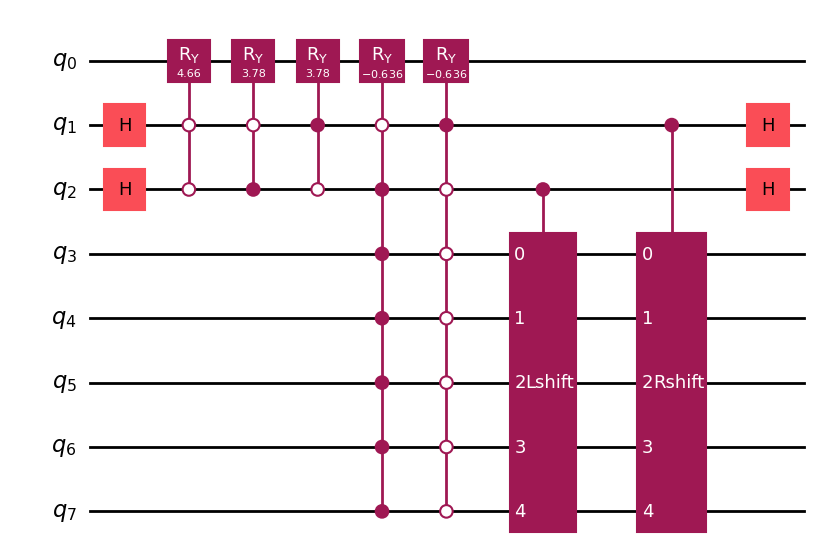

In [52]:
# backend = AerSimulator()

qc = QuantumCircuit(m+r+1,name="tridiagBE")
circuit = TridiagonalBlockEncoding(5,[tridiag_A[0,1],tridiag_A[0,0],tridiag_A[1,0]])
qc.append(circuit,list(range(0,m+r+1)))
# qc.measure(list(range(0,r+1)),list(range(0,r+1)))

circuit.decompose().draw('mpl')

## Verification through inner products !!! $Need to check$

In [83]:
i = 0
j = 1

print((format(i, f'0{m}b'))[::-1])
keti = Statevector.from_label((format(i, f'0{m}b'))[::-1])
ketj = Statevector.from_label((format(j, f'0{m}b'))[::-1])
# print(keti)
# print(ketj)

# Take tensor product of i with ket 0
ket0 = Statevector.from_label('0')
ket0r = Statevector.from_label('0'*r)

print((((ket0.tensor(ket0r)).tensor(keti)).evolve(qc)).inner((ket0.tensor(ket0r)).tensor(ketj)))

00000
(-7.014669448467934e-17-2.6892447518548114e-16j)


In [54]:
psi_0 = Statevector.from_label('11111'+'0'*r+'0')
# psi_0.draw("latex")
psi_f = psi_0.evolve(qc)
psi_f.draw('latex')


# Expand the output
amplitudes = psi_f.data
num_qubits = len(psi_f.dims())
basis_states = [format(i, f'0{num_qubits}b') for i in range(2**num_qubits)]

# Print the expanded output
for amplitude, basis_state in zip(amplitudes, basis_states):
    if abs(amplitude) > 1e-10:  # Filter out very small amplitudes
        print(f'{amplitude:.10f} |{basis_state}>')

0.2500000000-0.0000000000j |00000001>
0.2500000000-0.0000000000j |00000011>
-0.2500000000+0.0000000000j |00000101>
-0.2500000000+0.0000000000j |00000111>
-0.0781250000-0.0000000000j |01111000>
0.2374794399+0.0000000000j |01111001>
0.0781250000+0.0000000000j |01111010>
-0.2374794399-0.0000000000j |01111011>
-0.0781250000-0.0000000000j |01111100>
0.2374794399+0.0000000000j |01111101>
0.0781250000+0.0000000000j |01111110>
-0.2374794399-0.0000000000j |01111111>
0.0781250000-0.0000000000j |11111000>
0.1815460944-0.0000000000j |11111001>
-0.4218750000+0.0000000000j |11111010>
0.1815460944-0.0000000000j |11111011>
-0.4218750000+0.0000000000j |11111100>
0.1815460944-0.0000000000j |11111101>
0.0781250000-0.0000000000j |11111110>
0.1815460944-0.0000000000j |11111111>


In [84]:
Operator(circuit).data

array([[ 7.81250000e-02-9.66301442e-15j, -1.81546094e-01+1.55691432e-14j,
        -4.21875000e-01+4.02912921e-14j, ...,
         2.50000000e-01-1.90975185e-14j,  2.95313574e-16-1.52500093e-16j,
         2.50000000e-01-1.90975185e-14j],
       [ 1.81546094e-01-1.58137392e-14j,  7.81250000e-02-1.01436014e-14j,
         1.81546094e-01-1.58970059e-14j, ...,
        -2.97584348e-16+6.38079974e-16j, -2.50000000e-01+1.88789433e-14j,
        -3.20616050e-16+7.18087157e-16j],
       [-4.21875000e-01+4.02912921e-14j, -1.81546094e-01+1.47711704e-14j,
         7.81250000e-02-9.66301442e-15j, ...,
         2.50000000e-01-1.90975185e-14j,  3.14993506e-16-2.04094499e-16j,
         2.50000000e-01-1.90975185e-14j],
       ...,
       [ 2.50000000e-01-2.42910872e-14j,  1.59707662e-16-9.08053271e-16j,
        -2.50000000e-01+2.41912576e-14j, ...,
         7.81250000e-02-1.71437578e-14j,  1.81546094e-01-5.41769700e-15j,
        -4.21875000e-01+2.81002713e-14j],
       [ 4.36936596e-16+7.19992088e-17j,  2.